In [1]:
import numpy as np
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('fr_core_news_md')


In [28]:
# read data from text files
with open('cleanData.csv','r') as f:
    tweet = f.read()

#mettre minuscule
tweet = tweet.lower()

punctuation = "!\"#$%&'()*+-./:;<=>?@[\]^_`{|}~’"

all_tweet = ''.join([c for c in tweet if c not in punctuation])

#print(all_tweet[:50])

tweet_split = all_tweet.split('\n') 
label_split = all_tweet.split('\n') 

# separer tweet et label
for index,entry in enumerate(tweet_split):
    #print(index)
    if(index != 0):
        x = entry.split(',')
        if(len(x) != 1):
            tweet_split[index-1] = x[0]
            label_split[index-1] = x[1]

tweet_split = np.array(tweet_split)   
label_split = np.array(label_split)  
print (tweet_split[:3])
print ('Number of tweet :', len(tweet_split))

['bravo gars'
 'félicitation 2 fois encore mieux jaimerai être maman aussi chanceux fille falloir patience beaucoup chance etpeut être quaprès concert'
 'sioniste marcel connard trône train chier noter haut orgueil complexe supériorité rien plus affligeant monde depuis l  invention bêtis']
Number of tweet : 104068


In [29]:
# shuffle data
np.random.seed(354)

indices = np.arange(tweet_split.shape[0])
np.random.shuffle(indices)

tweet_split = tweet_split[indices]
label_split = label_split[indices]

#reduire taille echantillon
tweet_split = tweet_split[:70000]

#print (tweet_split[:3])

In [30]:
#create index mapping
from collections import Counter

all_tweet2 = ' '.join(tweet_split)
# create a list of words
words = all_tweet2.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

#print(sorted_words)


In [31]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

print (type(vocab_to_int))

<class 'dict'>


In [32]:
tweet_int = []
for tweet in tweet_split:
    r = [vocab_to_int[w] for w in tweet.split()]
    tweet_int.append(r)
print (tweet_int[0:3])

[[573, 10, 8605], [12, 139], [92, 10]]


In [33]:
#encode label
encoded_labels = [1 if label =='1' else 0 for label in label_split]
encoded_labels = np.array(encoded_labels)

print(sum(encoded_labels)/len(encoded_labels))

print(type(encoded_labels))

0.49868355306145984
<class 'numpy.ndarray'>


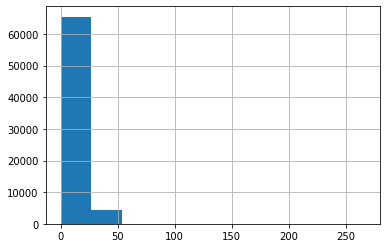

count    70000.000000
mean        10.944543
std          8.511726
min          0.000000
25%          4.000000
50%          9.000000
75%         16.000000
max        267.000000
dtype: float64

In [34]:
# analyse tweet length
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tweet_len = [len(x) for x in tweet_int]
pd.Series(tweet_len).hist()
plt.show()

pd.Series(tweet_len).describe()

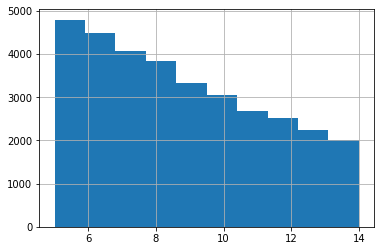

In [35]:
# remove outliers
tweet_int = [ tweet_int[i] for i, l in enumerate(tweet_len) if l>4 and l<15]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(tweet_len) if l> 4 and l<15]

tweet_len = [len(x) for x in tweet_int]
pd.Series(tweet_len).hist()
plt.show()

pd.Series(tweet_len).describe()

for i in tweet_int:
    i.reverse()
    
    

In [36]:
# paddin/trucate the remaining data
def pad_features(tweet_int, seq_length):
    ''' Return features of tweets_ints, where each tweet is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(tweet_int), seq_length), dtype = int)
    
    for i, tweet in enumerate(tweet_int):
        tweet_len = len(tweet)
        
        if tweet_len <= seq_length:
            zeroes = list(np.zeros(seq_length-tweet_len))
            new = zeroes+tweet        
            
        elif tweet_len > seq_length:
            new = tweet[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

features = pad_features(tweet_int,15)
print (features[:5,:])

[[    0     0     0     0     0     0     0     0  1514    22   459     1
    122  2541 17376]
 [    0     0     0     0     0     0     0  1060   224   162    52   557
     19 17377     6]
 [    0     0     0     0     0     0     0     0     0     0    10   721
   1114    18  5047]
 [    0     0     0     0     0     0     0     0     0     0 25593     9
     11   341     1]
 [    0     0     0     0     0 25594   190    17   164    28    17    21
     25   181     7]]


In [37]:
# Training, validation, test datasets 
len_feat = len(tweet_int)
split_frac = 0.8
train_x = features[0:int(split_frac*len_feat)]
train_y = np.array(encoded_labels[0:int(split_frac*len_feat)])

remaining_x = features[int(split_frac*len_feat):]
remaining_y = np.array(encoded_labels[int(split_frac*len_feat):])

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = np.array(remaining_y[0:int(len(remaining_y)*0.5)])

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = np.array(remaining_y[int(len(remaining_y)*0.5):])  

print(train_x)

[[    0     0     0 ...   122  2541 17376]
 [    0     0     0 ...    19 17377     6]
 [    0     0     0 ...  1114    18  5047]
 ...
 [    0     0     0 ...  7727   304    82]
 [    0     0     0 ...  5235 21594   848]
 [    0   818    31 ...   130    27   604]]


In [38]:
# Dataloaders and batching

import torch
from torch.utils.data import DataLoader, TensorDataset

#extends dimensions 
#train_data = np.expand_dims(train_data,axis=0)
#valid_data = np.expand_dims(valid_data,axis=0)
#test_data = np.expand_dims(test_data,axis=0)

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 15])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,   991,
            75, 17413,  6063,    31,    33],
        [    0,     0,     0,     0,     0,     0,     0,     0,   512,  5064,
          2859,  1418,    31,  5063,   442],
        [    0,     0,     0,     0,     0,     0,    49, 13578,  1789,  2139,
            78,   429,  2277,    38,    30],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0, 10640,
         11074,  9651,   576,   208,    12],
        [    0,     0,  1818,    80,  2485,  1956,   823, 54232,     1,  1667,
          3878,   129,    34,  1249,   212],
        [    0,     0,     0,     0,     0,     0,     0,     0,  1818,   324,
            26,   585,  1005,   678, 33713],
        [    0,     0,     0,  2223,   275,  2559,    48,   222,    78,    54,
            10,    39,    50,     3,    92],
        [    0,     0,     0,     0,     0, 28496, 28495,    11,  1053,    

In [39]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [40]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 200
hidden_dim = 256
n_layers = 3

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)


SentimentLSTM(
  (embedding): Embedding(68888, 200)
  (lstm): LSTM(200, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [41]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [42]:
# loss and optimization functions
lr=0.01

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 5 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=6 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
            
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                #inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/5... Step: 100... Loss: 0.318234... Val Loss: 0.111605
Epoch: 1/5... Step: 200... Loss: 0.154324... Val Loss: 0.096183
Epoch: 1/5... Step: 300... Loss: 0.132048... Val Loss: 0.087603
Epoch: 1/5... Step: 400... Loss: 0.040072... Val Loss: 0.092813
Epoch: 1/5... Step: 500... Loss: 0.037403... Val Loss: 0.086540
Epoch: 2/5... Step: 600... Loss: 0.076495... Val Loss: 0.080431
Epoch: 2/5... Step: 700... Loss: 0.015116... Val Loss: 0.094441
Epoch: 2/5... Step: 800... Loss: 0.028375... Val Loss: 0.079732
Epoch: 2/5... Step: 900... Loss: 0.067484... Val Loss: 0.089470
Epoch: 2/5... Step: 1000... Loss: 0.074311... Val Loss: 0.081677
Epoch: 3/5... Step: 1100... Loss: 0.026583... Val Loss: 0.124457
Epoch: 3/5... Step: 1200... Loss: 0.027192... Val Loss: 0.105301
Epoch: 3/5... Step: 1300... Loss: 0.030637... Val Loss: 0.098996
Epoch: 3/5... Step: 1400... Loss: 0.029730... Val Loss: 0.104819
Epoch: 3/5... Step: 1500... Loss: 0.078280... Val Loss: 0.085813
Epoch: 4/5... Step: 1600... Loss: 

In [43]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    #print(type(output))
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.122
Test accuracy: 0.954


In [44]:
ponctuation = "!\"#$%&'()*+-./:;<=>?@[\]^_`{|}~’"

def preprocess(tweet, vocab_to_int):
    tweet = tweet.lower()
    
    #enlever ponctuation
    tweet = ''.join([c for c in tweet if c not in punctuation])
    
    #enlever les liens
    indice = tweet.find("http")
    if indice != -1:
        tweet = tweet[:indice]    

    #remove stopwords
    x = tweet.split()
    text_final = ""
    
    for word in x:
        if word not in stopwords.words('french'):
            text_final = text_final+" "+word
         
    tweet = text_final 
    
    #lemmatisation
    doc = nlp(tweet)
    text_final = ""
    for token in doc:
        text_final = text_final+" "+token.lemma_
        
    tweet = text_final.strip() 

    word_list = tweet.split()
    num_list = []
    #list of reviews
    #though it contains only one review as of now
    tweets_int = []
    for word in word_list:
        if word in vocab_to_int.keys():
            num_list.append(vocab_to_int[word])
    tweets_int.append(num_list)
    return tweets_int

In [45]:
def predict(net, test_tweet, sequence_length=30):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''

    #change the reviews to sequence of integers
    int_rev = preprocess(test_tweet, vocab_to_int)
    #pad the reviews as per the sequence length of the feature
    features = pad_features(int_rev, seq_length=seq_length)
    
    #changing the features to PyTorch tensor
    features = torch.from_numpy(features)
    
    #pass the features to the model to get prediction
    net.eval()
    val_h = net.init_hidden(1)
    val_h = tuple([each.data for each in val_h])

    if(train_on_gpu):
        features = features.cuda()

    output, val_h = net(features, val_h)
    
    #rounding the output to nearest 0 or 1
    #pred = torch.round(output)
    
    #mapping the numeric values to postive or negative
    #output = ["Positive" if pred.item() == 0 else "Negative"]
    
    # print custom response based on whether test_review is pos/neg
    return output.item()

In [47]:
seq_length=15
my_tweet_neutre = "Bonjour, je suis heureux aujourd'hui"
my_tweet_neutre2 = "Merci beaucoup pour votre soutient c'est tres gentil"

my_tweet_mauvais = "Les violeurs comme toi merite d'aller en taule fils de pute"
my_tweet_mauvais2 = "T'etonne pas si on t'attend a la sortie du college"

my_tweet_test = "c'est le seul Raoul en qui j'ai confiance"

print(my_tweet_neutre + " : " + str(predict(net, my_tweet_neutre, seq_length)))
print(my_tweet_neutre2 + " : " + str(predict(net, my_tweet_neutre2, seq_length)))
print()
print(my_tweet_mauvais + " : " + str(predict(net, my_tweet_mauvais, seq_length)))
print(my_tweet_mauvais2 + " : " + str(predict(net, my_tweet_mauvais2, seq_length)))
print()
print(my_tweet_test + " : " + str(predict(net, my_tweet_test, seq_length)))

Bonjour, je suis heureux aujourd'hui : 0.0007397727458737791
Merci beaucoup pour votre soutient c'est tres gentil : 0.1904749572277069

Les violeurs comme toi merite d'aller en taule fils de pute : 0.9991791844367981
T'etonne pas si on t'attend a la sortie du college : 0.09213431924581528

c'est le seul Raoul en qui j'ai confiance : 0.7078825235366821


In [49]:
def saveModel(net, name):
    torch.save(net.state_dict(), name+'.pth')

In [28]:
def loadModel(name):
    vocab_size = 30916 # +1 for the 0 padding
    output_size = 1
    embedding_dim = 200
    hidden_dim = 256
    n_layers = 2
    model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
    model.load_state_dict(torch.load(name+'.pth'))
    model.eval()

    if(train_on_gpu):
        model.cuda()
    
    return model

In [232]:
saveModel(net, 'model_70k_3c_50b_5e_len15')

In [57]:
loadModel('model2')

In [233]:
import codecs
import json

with codecs.open('vocab_to_int-70k_3c_50b_5e_len15.json', 'w', encoding='utf-8') as f:
    json.dump(vocab_to_int, f, ensure_ascii=False)

In [45]:
with open('vocab_to_int.json') as f:
    data = json.load(f)
   
type(data)

dict

In [46]:
with codecs.open('tweet_int.json', 'w', encoding='utf-8') as f:
    json.dump(tweet_int, f, ensure_ascii=False)
    
with open('tweet_int.json') as f:
    data2 = json.load(f)
   
    

list